# Exercise 1.2
## This *.ipynb file contains:



In [59]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from lib.Exercise1_1 import LQRSolver

from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
# Initialization for solver: Define the matrices and parameters for the LQR solver.
H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=torch.double)
M = torch.tensor([[0.5, 0.7], [0.3, 1.0]], dtype=torch.double)
sigma = torch.tensor([[[0.08], [0.11]]], dtype=torch.double) 
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=torch.double)  # Positive semi-definite
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=torch.double)  # Positive definite
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=torch.double)  # Positive semi-definite
T = torch.tensor(1.0, dtype=torch.double)
method = 'rk4'

# Create a directory for Exercise 1.2 if it doesn't exist.
file_path_Ex1_2 = 'Exercise1_2'
os.makedirs(file_path_Ex1_2, exist_ok=True)

# Store the initialization parameters for the solver.
initialization_for_solver = {
    'H': H,
    'M': M,
    'sigma': sigma,
    'C': C,
    'D': D,
    'R': R,
    'T': T,
    'method': method
}
torch.save(initialization_for_solver, os.path.join(file_path_Ex1_2, 'initialization_for_solver.pt'))

# Instantiate the solver with the given parameters.
solver = LQRSolver(H, M, sigma, C, D, R, T, method)

## Error Analysis

### Original Setting

- Set time horizon as $[0,T], T = 1$ 

- Calculate $v(t,x)$ on $(t,x) \in \{0.1,0.2,...,0.9\} \times \{0.1,0.2,...,0.9\}^2$

- For each $t \in \{0.1,0.2,...,0.9\}$, compare __the 2-D graphs__ of numerical solutions and Monte Carlo results, and Calculate the __MSE__ at __each time point__ (denoted as $MSE_{t_i}$) and on __the whole space__ (denoted as $MSE$) as the final criterion for the entire simulation at this time.

### Setting

- Set time horizon as $[0,T], T = 1$ 

- Calculate $v(t,x)$ on $(t,x) \in \{0.1\} \times \{0.5\}^2$

- For each $t \in \{0.1\}$, compare __the 2-D graphs__ of numerical solutions and Monte Carlo results, and Calculate the __MSE__ at __each time point__ (denoted as $MSE_{t_i}$) and on __the whole space__ (denoted as $MSE$) as the final criterion for the entire simulation at this time.

In [61]:
# Setting for Error Comparison
# Initialization of parameters for the numerical solution calculation

# Define the start and end points of the time interval as well as the number of intervals (t_num)
t_ends = [0.1, 0.1]
t_num = 1

# Define the start and end points of the state intervals (x_ends) and the number of intervals (x_num) for each state dimension
x_ends = [[0.5, 0.5], [0.5, 0.5]]
x_num = [1, 1]

# Create a directory for storing the numerical values associated with this setting
file_path_numerical = os.path.join(file_path_Ex1_2, f'value_numerical/{x_num[0]}x{x_num[1]}')
os.makedirs(file_path_numerical, exist_ok=True)

# Establish meshgrid structure for t and x from setting
# Generate a tensor of time points evenly spaced between t_ends[0] and t_ends[1] with t_num intervals
t_batch_i = torch.linspace(t_ends[0], t_ends[1], t_num, dtype=torch.double)
# Repeat t_batch_i to match the number of state samples
t_batch = t_batch_i.repeat_interleave(x_num[0] * x_num[1])

# Generate tensors for each state dimension using the specified intervals and number of intervals
x1 = torch.linspace(x_ends[0][0], x_ends[0][1], x_num[0], dtype=torch.double)
x2 = torch.linspace(x_ends[1][0], x_ends[1][1], x_num[1], dtype=torch.double)

# Create a batch of state samples by taking the cartesian product of x1 and x2, then add a dimension for batch handling
x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)

# Convert state samples into a meshgrid format for easier visualization and manipulation
X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])

# Repeat state samples to match the number of time samples
x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)

# Calculate the value function for the generated time and state samples using the numerical solution from the solver
value_numerical = solver.value_function(t_batch, x_batch)

# Preparing data for visualization
# Find the minimum and maximum values of the computed value function for setting graph limits
value_min = torch.min(value_numerical).numpy()
value_max = torch.max(value_numerical).numpy()
# Reshape the value function tensor for easier access during plotting
value_numerical_reshape = value_numerical.reshape([t_num, x_num[0] * x_num[1]]).view(t_num, x_num[0], x_num[1])

interval_setting = {
    't_ends': t_ends,
    't_num': t_num,
    'x_ends': x_ends,
    'x_num': x_num
}

# Save the interval_setting and the corresponding obtained value data.

torch.save(interval_setting, file_path_numerical+'/'+'interval_setting.pt')
torch.save(value_numerical, file_path_numerical+'/'+'value_numerical.pt')



In [71]:
# Setting for Monte Carlo
# According to the requirements, build two folders for storing data.

load_interval_setting = torch.load('Exercise1_2/value_numerical/1x1/'+'interval_setting.pt')
t_ends = load_interval_setting['t_ends']
t_num = load_interval_setting['t_num']
x_ends = load_interval_setting['x_ends']
x_num = load_interval_setting['x_num']

# Due to the large numercial work to deal with, we seperate it
# ____________________________________________________Workload Assignment____________________________________________________

# Zheyan Lu: FSS_VSTN[1e0,1e1,5e1], FTSN_VSS[1e1,5e1,1e2,5e2]

# Yu Wang: FSS_VSTN[1e2,5e2,1e3], FTSN_VSS[1e3,5e3,1e4]

# Yuebo Yang: FSS_VSTN[5e3], FTSN_VSS[5e4,1e5]

# ___________________________________________________________________________________________________________________________



# ____________________________________________________Fixed sampling size____________________________________________________
FSS = int(1e5)


file_path_MC_FSS = file_path_Ex1_2 + '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FSS_1e5'
#file_path_MC_FSS = file_path_Ex1_2 + '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FSS_1e2_for_test'

# Varied time step number.
# _________________________________________________Paste your workload here:_________________________________________________
FSS_VTSN = [int(x) for x in[1e0,1e1,5e1,1e2,5e2,1e3,5e3]]




# __________________________________________________Fixed time step number___________________________________________________
FTSN = int(5e3)

file_path_MC_FTSN = file_path_Ex1_2 + '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FTSN_5e3'
# file_path_MC_FTSN = file_path_Ex1_2 + '/' + f'value_MC/{x_num[0]}x{x_num[1]}/FTSN_5e1_for_test'

# Varied sampling size.

# _________________________________________________Paste your workload here:_________________________________________________
FTSN_VSS = [int(x) for x in[1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5]]



# Preparing the interval settings for time and state variables
t_batch_i = torch.linspace(t_ends[0], t_ends[1], t_num, dtype=torch.double)  # Create tensor of linearly spaced points in time

x1 = torch.linspace(x_ends[0][0], x_ends[0][1], x_num[0], dtype=torch.double)  # Linearly spaced points for the first state variable
x2 = torch.linspace(x_ends[1][0], x_ends[1][1], x_num[1], dtype=torch.double)  # Linearly spaced points for the second state variable

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)  # Generate cartesian product of x1 and x2, add batch dimension

# Compile interval settings into a dictionary for easy access and storage
interval_setting = {
    't_ends': t_ends,  # Time interval ends
    't_num': t_num,    # Number of time intervals
    'x_ends': x_ends,  # State variable interval ends
    'x_num': x_num     # Number of intervals for each state variable
}

# Prepare to generate a shell script for running Monte Carlo simulations with different settings
shell_script_path = "run_MCs.sh"  # Define the shell script's file name

# Open a new file to write the shell script
with open(shell_script_path, 'w') as shell_script:
    shell_script.write("#!/bin/bash\n\n")  # Write the shebang line for bash script
    # Optional: Command to activate Python environment for MacOS
    # shell_script.write("source ../env_SCDAA/bin/activate\n\n")  # Uncomment if needed
    
    # Loop through the different settings of fixed sampling size with varied time step numbers (FSS_VTSN)
    for i in FSS_VTSN:
        # Handle singular vs plural naming
        if i == 1:
            trvlthg = ''
        else:
            trvlthg = 's'
        # Create a path for each setting and ensure the directory exists
        path_FSS_VTSN_i = f"{file_path_MC_FSS}/{i}_step{trvlthg}"
        os.makedirs(path_FSS_VTSN_i, exist_ok=True)
        
        # Save the interval setting to the newly created directory
        torch.save(interval_setting, os.path.join(path_FSS_VTSN_i, 'interval_setting.pt'))
        
        # Command to run the parallel Monte Carlo simulation Python script with current settings
        shell_script.write(f'python {script_path} {path_FSS_VTSN_i} {i} {FSS} &\n')  # '&' allows running simulations in parallel
    
 
    # Repeat the process for varied sampling size with a fixed time step number (FTSN_VSS)
    for i in FTSN_VSS:
        # Create a directory for each setting
        path_FTSN_VSS_i = f"{file_path_MC_FTSN}/{i}_samples"
        os.makedirs(path_FTSN_VSS_i, exist_ok=True)
        
        # Save interval settings
        torch.save(interval_setting, os.path.join(path_FTSN_VSS_i, 'interval_setting.pt'))
        
        # Write the command to execute Monte Carlo simulations with the current settings
        shell_script.write(f'python {script_path} {path_FTSN_VSS_i} {FTSN} {i} &\n')


#os.system(f"chmod +x {shell_script_path}")
print('The run_MCs.sh file has already been created! Please run\"sh run_MCs.sh\" in the root direction to start all the Monte Carlo Simulations with the specified parameters(sample_size and time_step_number). The outcomes would be stored in the correspoding sub-folders.')

# Next, please run"sh run_MCs.sh" in the root direction to start all the Monte Carlo Simulations.

The run_MCs.sh file has already been created! Please run"sh run_MCs.sh" in the root direction to start all the Monte Carlo Simulations with the specified parameters(sample_size and time_step_number). The outcomes would be stored in the correspoding sub-folders.


In [63]:
# After all the MCs, collect and analyse all the data here.
# Load the interval setting used for the Monte Carlo simulations
load_interval_setting = torch.load('Exercise1_2/value_numerical/1x1/'+'interval_setting.pt')
t_ends = load_interval_setting['t_ends']  # Time interval range
t_num = load_interval_setting['t_num']    # Number of time intervals
x_ends = load_interval_setting['x_ends']  # State variable interval ranges
x_num = load_interval_setting['x_num']    # Number of intervals for each state variable

# Generate a meshgrid structure for the setting based on the loaded interval settings
t_batch_i = torch.linspace(t_ends[0], t_ends[1], t_num, dtype=torch.double)  # Create tensor of linearly spaced points in time
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])  # Repeat time points for each state variable combination

x1 = torch.linspace(x_ends[0][0], x_ends[0][1], x_num[0], dtype=torch.double)  # Linearly spaced points for the first state variable
x2 = torch.linspace(x_ends[1][0], x_ends[1][1], x_num[1], dtype=torch.double)  # Linearly spaced points for the second state variable

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)  # Generate cartesian product of x1 and x2, add batch dimension

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])  # Reshape for the first state variable
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])  # Reshape for the second state variable

# Calculate the value function using the numerical solution from the LQR solver
# This step computes the value function for each combination of time and state variables
value_numerical = solver.value_function(t_batch, x_batch)

In [64]:
# Load the numerical solution data for value function
J_MC = torch.load(file_path_numerical+'/value_numerical.pt')

# Initialize list to store Mean Squared Error (MSE) values for various time step numbers under a fixed sampling size (FSS)
MSE_FSS_VTSN = []

# Iterate over various numbers of time steps to analyze convergence behavior
for i in FSS_VTSN:
    # Handle singular vs plural in file naming
    trvlthg = '' if i == 1 else 's'
    path_FSS_VTSN_i = f"{file_path_MC_FSS}/{i}_step{trvlthg}"

    # Load the Monte Carlo simulation results
    J_load_test = torch.load(path_FSS_VTSN_i + '/value_MC.pt')
    
    # Process the data as needed, here taking the minimum value across dimensions
    J_processed,_ = torch.min(J_load_test, dim=1)

    # Compute the squared difference between the Monte Carlo results and the numerical solution
    diff = J_processed - J_MC
    MSE_FSS_VTSN.append(diff**2)  # Append the MSE to the list

# Initialize list for MSE values for various sample sizes under a fixed number of time steps (FTSN)
MSE_VSS_FTSN = []

# Iterate over various sample sizes to analyze convergence behavior with respect to sample size
for i in FTSN_VSS:
    path_FTSN_VSS_i = f"{file_path_MC_FTSN}/{i}_samples"

    # Load Monte Carlo simulation results for the current sample size
    J_load_test = torch.load(path_FTSN_VSS_i + '/value_MC.pt')
    
    # Process the Monte Carlo data as needed
    J_processed,_ = torch.min(J_load_test, dim=1)

    # Compute and store the MSE between Monte Carlo results and numerical solution for the current sample size
    diff = J_processed - J_MC
    MSE_VSS_FTSN.append(diff**2)



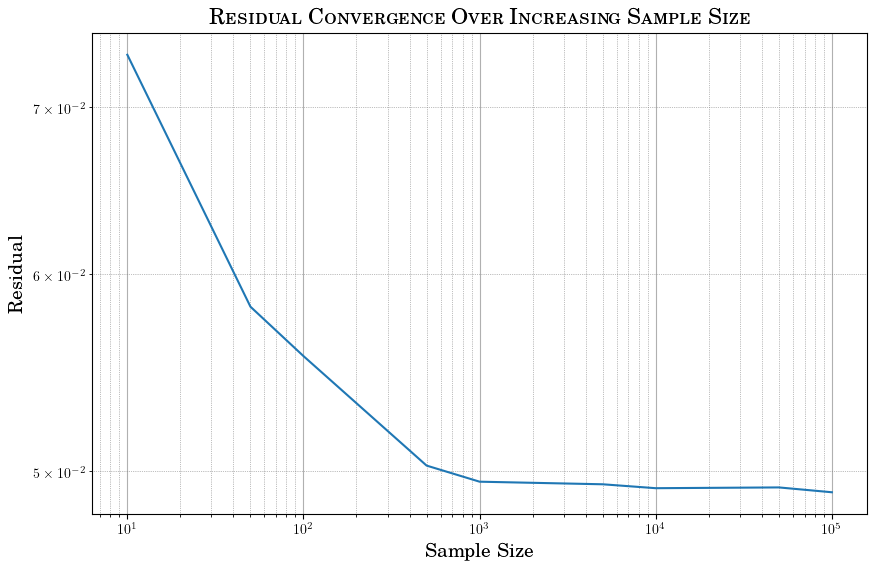

In [68]:
# Enable LaTeX text rendering in plots for high-quality text
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Plot for Convergence Over Increasing Sample Size
plt.figure(figsize=(10, 6.25))
plt.plot(FTSN_VSS, MSE_VSS_FTSN)  # Plotting the sample size vs. mean squared error

plt.xscale('log')  # Use logarithmic scale for x-axis (sample size)
plt.yscale('log')  # Use logarithmic scale for y-axis (residual)

# Setting labels and title with proper formatting
plt.xlabel(r'\rmfamily \textmd {Sample Size}', fontsize=14)
plt.ylabel(r'\rmfamily \textmd {Residual}', fontsize=14)
plt.title(r'\rmfamily {\textsc{Residual Convergence Over Increasing Sample Size}}', fontsize=16)

# Enable grid for better readability, with minor grid lines as well
plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

# Save the plot to EPS and PNG for high quality and accessibility
plt.savefig('Exercise1_2/Residual Convergence Over Increasing Sample Size.eps', format='eps', dpi=600)
plt.savefig('Exercise1_2/Residual Convergence Over Increasing Sample Size.png', format='png', dpi=600)

plt.show()  # Display the plot



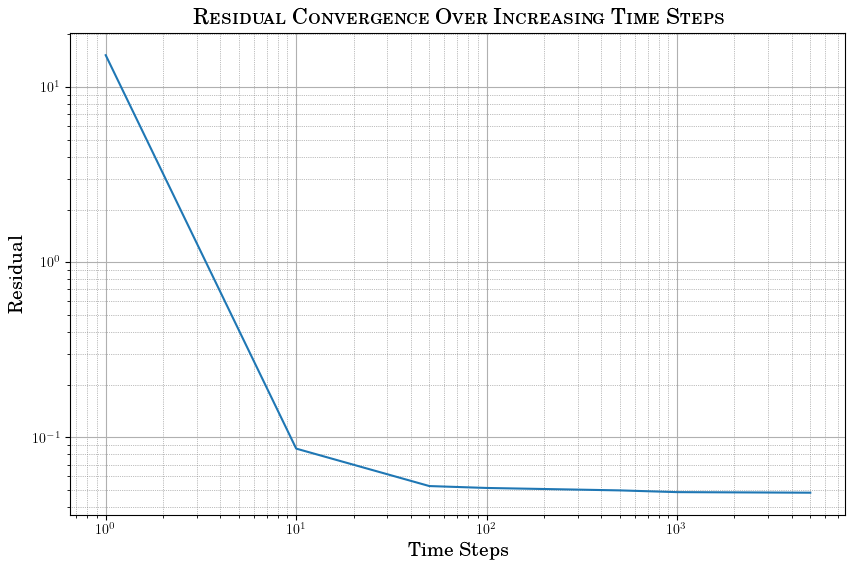

In [69]:
# Plot for Convergence Over Increasing Time Steps
plt.figure(figsize=(10, 6.25))
plt.plot(FSS_VTSN, MSE_FSS_VTSN)  # Plotting the time steps vs. mean squared error

plt.xscale('log')  # Use logarithmic scale for x-axis (time steps)
plt.yscale('log')  # Use logarithmic scale for y-axis (residual)

# Setting labels and title with proper formatting
plt.xlabel(r'\rmfamily \textmd {Time Steps}', fontsize=14)
plt.ylabel(r'\rmfamily \textmd {Residual}', fontsize=14)
plt.title(r'\rmfamily {\textsc{Residual Convergence Over Increasing Time Steps}}', fontsize=16)

# Enable grid for better readability, with minor grid lines as well
plt.grid(True)
plt.minorticks_on()  # Enable minor grid lines for detailed scale
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

# Save the plot to EPS and PNG for high quality and accessibility
plt.savefig('Exercise1_2/Residual Convergence Over Increasing Time Steps.eps', format='eps', dpi=600)
plt.savefig('Exercise1_2/Residual Convergence Over Increasing Time Steps.png', format='png', dpi=600)

plt.show()  # Display the plot